In [11]:
import numpy as np
import scipy as sci
import scipy.special as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba as nb
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# Basic Definitions

In [200]:
vec_norm = np.linalg.norm
det = np.linalg.det
erfc = sp.erfc
twopi = 2.0*np.pi

class Lattice:
    def __init__(self, a1, a2, a3, lat_size=1.0, gvec_normalize=False):
        if det([a1, a2, a3]) == 0.0:
            raise ValueError("Basis vectors are linear dependent!")
        else:
            self.lat_size = lat_size
            self.a1 = np.asarray(a1)*self.lat_size
            self.a2 = np.asarray(a2)*self.lat_size
            self.a3 = np.asarray(a3)*self.lat_size
            self.lat_basis = np.array([self.a1, self.a2, self.a3])
            self.uc_vol = np.abs( det([self.a1, self.a2, self.a3]) )
            if gvec_normalize:
                twopi_o_vol = 1.0
            else:
                twopi_o_vol = twopi/self.uc_vol
            self.b1 = twopi_o_vol*np.cross(self.a2, self.a3)
            self.b2 = twopi_o_vol*np.cross(self.a3, self.a1)
            self.b3 = twopi_o_vol*np.cross(self.a1, self.a2)
            self.reci_basis = np.array([self.b1, self.b2, self.b3])
    
    def lat_vec(self, c1, c2, c3=0.0):
        return c1*self.a1 + c2*self.a2 + c3*self.a3
    
    def reci_vec(self, g1, g2, g3=0.0):
        return g1*self.b1 + g2*self.b2 + g3*self.b3

def gvec(n1, n2, lat):
    return [ lat.reci_vec(g1, g2) 
            for g1 in np.linspace(-n1, n1, 2*n1+1)
            for g2 in np.linspace(-n2, n2, 2*n2+1) ]

def rmesh(nx, ny, lat, rmin=1j, rmax=1e8):
    x = np.arange(-nx, nx+1)
    y = np.arange(-ny, ny+1)
    xs, ys = np.meshgrid(x, y)
    ax, ay = lat.a1, lat.a2
    mask = ( (xs*ax[0])**2 + (ys*ay[1])**2 > rmin**2 ) &\
    ( (xs*ax[0])**2 + (ys*ay[1])**2 < rmax**2 )
    grid = np.tensordot(xs[mask], ax, axes=0) + \
    np.tensordot(ys[mask], ay, axes=0)
    return grid
    
def gmesh(nx, ny, lat, gmin=-1.0, gmax=None):
    gx, gy = lat.b1, lat.b2
    if gmax is None:
        gmax = 1e8
    else:
        scale = 2
        nx = scale*np.int(np.floor(gmax/vec_norm(gx)))
        ny = scale*np.int(np.floor(gmax/vec_norm(gy)))
    x = np.arange(-nx, nx+1)
    y = np.arange(-ny, ny+1)
    xs, ys = np.meshgrid(x, y)
    grid = np.tensordot(xs, gx, axes=0) + \
    np.tensordot(ys, gy, axes=0)
    mask = ( vec_norm(grid, axis=2) > gmin ) &\
    ( vec_norm(grid, axis=2) <= gmax )
    return grid[mask]

def g1term(rvec, kvec, kw, E, g, lat):
    g = np.atleast_2d(g)
    k = np.asarray(kvec)
    r = np.asarray(rvec)
    kz = sci.sqrt(kw**2 - vec_norm(k+g, axis=1)**2)
    z = r[2]
    uc_vol = lat.uc_vol
    return np.pi*1j/uc_vol*np.exp(1j*np.dot(k+g, r))/kz* \
           ( np.exp(1j*kz*z)*erfc(-1j*kz/2.0/E - E*z) + \
            np.exp(-1j*kz*z)*erfc(-1j*kz/2.0/E + E*z) )

def g1_sum(nx, ny, rvec, kvec, kw, E, lat, grid=None):
    if grid is None:
        grid = gmesh(nx, ny, lat)
    return np.sum( g1term(rvec, kvec, kw, E, grid, lat) )

def g2term(rvec, kvec, kw, E, Rvec, lat):
    k = np.asarray(kvec)
    r = np.asarray(rvec)
    R = np.atleast_2d(Rvec)
    eik = np.exp(1j*np.dot(R, k))
    rR = vec_norm(r-R, axis=1)
    ikw2E = 1j*kw/2.0/E
    return 0.5*eik/rR* \
            ( np.exp(1j*kw*rR)*erfc(E*rR + ikw2E) + \
             np.exp(-1j*kw*rR)*erfc(E*rR - ikw2E) )

def g2_sum(nx, ny, rvec, kvec, kw, E, lat, grid=None):
    if grid is None:
        grid = rmesh(nx, ny, lat)
    return np.sum( g2term(rvec, kvec, kw, E, grid, lat) )

def g3(kw, E):
    return - 1.0*1j*kw*erfc(-1j*kw/2.0/E) \
    - 1.0*2*E/np.sqrt(np.pi)*np.exp(kw**2/4.0/E**2)

def S_ewald(k, kw, N_G, N_R, E, lat, c1, c2, c3):
    r0 = [0, 0, 0]
    rs = rmesh(N_R, N_R, lat, rmin=0)
    Gsum = g1_sum(N_G, N_G, r0, k, kw, E, lat)
    Rsum = g2_sum(N_R, N_R, r0, k, kw, E, lat, grid=rs)
    other = - 1.0*1j*kw*erfc(-1j*kw/2.0/E) \
    - 1.0*2*E/np.sqrt(np.pi)*np.exp(kw**2/4.0/E**2)
    return c1*Gsum + c2*Rsum + c3*other

def fR1(Rvec):
    Rvec = np.atleast_2d( Rvec )
    return 1.0/vec_norm(Rvec, axis=1)

def Rsum_direct(func, numR, rvec, kvec, kw, lat):
    '''
    numpy vectorized version for direct real-space 
    lattice sum S(k, kw)
    '''
    grid = rmesh(numR, numR, lat, rmin=0)
    terms = np.exp( 1j*np.dot(grid, kvec) ) * \
    np.exp( 1j*kw*vec_norm(rvec - grid, axis=1) ) * func(grid)
    return np.sum(terms)

def plot_grid(grid, marker='o', pointsize=4,\
              if_save=False, filename='grid.pdf'):
    plt.figure(figsize=(6,6))
#     X = [ r[0] for r in grid ]
#     Y = [ r[1] for r in grid ]
    X = grid[:, 0]
    Y = grid[:, 1]
    nx = len(X)
    ny = len(Y)
    plt.plot(X, Y, marker, markersize=pointsize)
    plt.grid('on')
    plt.axis('equal')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(r'${}$ Grid Points'.format(nx))
    plt.tight_layout()
    if if_save:
        plt.savefig(filename)
    plt.show()

square = Lattice(a1=[1, 0, 0], a2=[0, 1, 0], a3=[0, 0, 1])
triangular = Lattice(a1=[0.5, 0.5*np.sqrt(3), 0], 
                     a2=[0.5, -0.5*np.sqrt(3), 0], 
                     a3=[0, 0, 1])

# ################################################
# Comparison of two versions of G-grid generation
# ################################################
# %time grid = gmesh(1000, 1000, square)
# %time grid2 = gvec(1000, 1000, square)
# '''
# CPU times: user 165 ms, sys: 129 ms, total: 294 ms
# Wall time: 324 ms
# CPU times: user 22.8 s, sys: 626 ms, total: 23.4 s
# Wall time: 23.8 s
# '''

# #############################
# Grid function gmesh test
# #############################
# nx, ny = 200, 200
# print(2*(nx+1)*2*(ny+1))
# lat = square
# %time grid = gmesh(nx, ny, lat, gmin=nx/10*vec_norm(lat.b1), \
#                    gmax=nx/2*vec_norm(lat.b1))
# %time plot_grid(grid)

def Ggrid(z, U, lat, scale=2):
    z = np.asarray(z)
    Gmax = U/z
    nx = np.int(np.floor(Gmax/vec_norm(lat.b1)))
    ny = np.int(np.floor(Gmax/vec_norm(lat.b2)))
    nx = scale*nx
    ny = scale*ny
    grid = gmesh(nx, ny, lat, gmin=0.0, gmax=Gmax)
    return grid

def Lsum(z, U, lat):
    Gs = Ggrid(z, U, lat)
    V_G = twopi**2/lat.uc_vol
    G = vec_norm(Gs, axis=1)
    return V_G/twopi*np.sum( np.exp(-G*z)/G )

def f1z(z, U, lat):
    z = np.asarray(z)
    L = Lsum(z, U, lat)
    return np.log( z*L + np.exp(-U) )/z

def f2z(z, U, lat):
    z = np.asarray(z)
    L = Lsum(z, U, lat)
    return L + ( np.exp(-U) - 1.0 )/z

def D_const(U, lat, nz=10):
    zz = np.linspace(0.005, 0.05, nz)
    f1 = [ f1z(z, U, lat) for z in zz ]
    f2 = [ f2z(z, U, lat) for z in zz ]
    d1 = np.polyfit(zz, f1, 1)[-1]
    d2 = np.polyfit(zz, f2, 1)[-1]
    return 0.5*(d1+d2)

def g0term(k, kw, g):
    g = np.atleast_2d(g)
    return 1.0/sci.sqrt(kw**2 - vec_norm(k + g, axis=1)**2) -\
           1.0/vec_norm(g, axis=1)/1.0j
#     return 1.0/sci.sqrt(vec_norm(k + g, axis=1)**2 - kw**2) -\
#            1.0/vec_norm(g, axis=1)

def sumG(k, kw, Gmax, lat):
    grid = Ggrid(1.0, Gmax, lat, scale=2)
    return np.sum( g0term(k, kw, grid) )

def S_simowski(k, kw, Gmax, D, lat):
    sg = twopi*1j/lat.uc_vol*sumG(k, kw, Gmax, lat)
    kz = sci.sqrt(kw**2-np.dot(k, k))
    return D + twopi*1j/lat.uc_vol/kz - 1j*kw + sg

def fRn(Rvec, n):
    '''
    Returns an algebraically decaying potential f(R) = 1/R^n, R=|Rvec|
    '''
    Rvec = np.atleast_2d( Rvec )
    return 1.0/vec_norm(Rvec, axis=1)**n

fR1 = lambda Rvec: fRn(Rvec, 1)
fR2 = lambda Rvec: fRn(Rvec, 2)
fR3 = lambda Rvec: fRn(Rvec, 3)

def Rsum_direct(func, numR, rvec, kvec, kw, lat):
    '''
    numpy vectorized version for direct real-space 
    lattice sum S(k, kw)
    '''
    grid = rmesh(numR, numR, lat, rmin=0)
    terms = np.exp( 1j*np.dot(grid, kvec) ) * \
    np.exp( 1j*kw*vec_norm(rvec - grid, axis=1) ) * func(grid)
    return np.sum(terms)

# Simowski-Zhen Method Test

## Displaying the extrapolation process for $D$

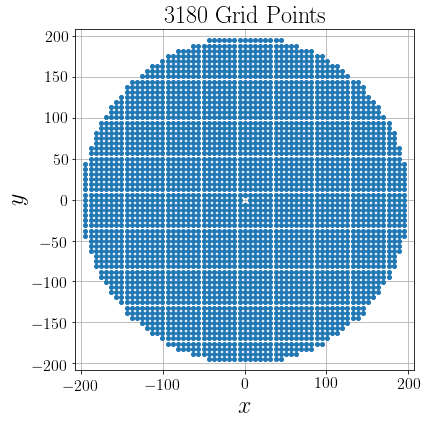

In [578]:
#################################################
#   Displaying the extrapolation process for D
#################################################
lat = square
nz = 10
U = 10.0
zz = np.linspace(0.005, 0.05, nz)
# # Plot the L-sum grid at intermediate z
# z = zz[int(len(zz)/2)]
z0 = 0.05
grid = Ggrid(z0, U, lat)
plot_grid(grid)

Linear fit of f1(z) and f2(z) gives D: D1=-3.9004 and D2=-3.8978
Average D=-3.8991
Deviation with Zhen's D: 2.8646e-04


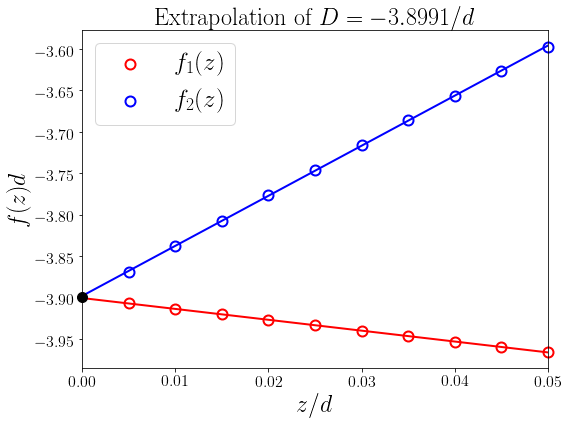

In [576]:
f1 = [ f1z(z, U, lat) for z in zz ]
f2 = [ f2z(z, U, lat) for z in zz ]    
# %time D = D_const(U, lat)
# print('D={:.4f}'.format(D))

# Extrapolate f1 and f2 to z->0 to get D
zz_fit = np.linspace(0, 0.05, 51)
c1 = np.polyfit(zz, f1, 1)
f1_fit = np.poly1d(c1)
d1 = c1[-1]
c2 = np.polyfit(zz, f2, 1)
f2_fit = np.poly1d(c2)
d2 = c2[-1]
D = 0.5*(d1+d2)
print('Linear fit of f1(z) and f2(z) gives D: D1={:.4f} and D2={:.4f}'\
      .format(d1, d2))
print('Average D={:.4f}'.format(0.5*(d1+d2)))
D0 = -3.9002
err = np.abs( ( D - D0 ) / D0 )
print("Deviation with Zhen's D: {:.4e}".format(err))

plt.figure(figsize=(8,6))
plt.plot(zz, f1, 'ro', label='$f_1(z)$', \
         markersize=10, markerfacecolor='None', \
         markeredgewidth=2, clip_on=False)
plt.plot(zz, f2, 'bo', label='$f_2(z)$', \
         markersize=10, markerfacecolor='None', \
         markeredgewidth=2, clip_on=False)
plt.plot(zz_fit, f1_fit(zz_fit), 'r-')
plt.plot(zz_fit, f2_fit(zz_fit), 'b-')
plt.plot(0, 0.5*(d1+d2), 'ko', markersize=10, clip_on=False)
plt.title("Extrapolation of $D={:.4f}/d$".format(0.5*(d1+d2)))
plt.xlim((0, zz[-1]))
plt.xlabel('$z/d$')
plt.ylabel('$f(z)d$')
plt.legend(loc='best', fontsize=25)
plt.tight_layout()
plt.savefig('f1f2.pdf')
plt.show()

[ 6.61387927  0.          0.        ] [ 0.          6.61387927  0.        ]


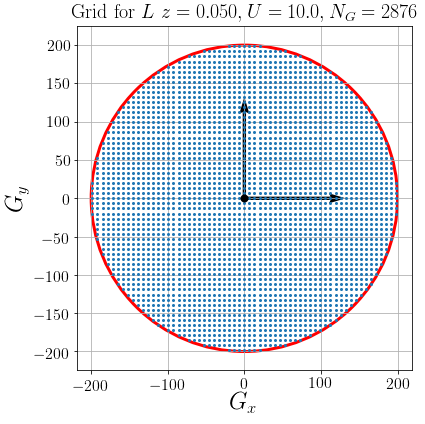

In [579]:
# Plot L-sum Grid
# grid = np.array(Ggrid(1.0, 3*twopi*np.sqrt(2), square0))/twopi
nz = 10
zz = np.linspace(0.005, 0.05, nz)
zz_fit = np.linspace(0, 0.05, 51)
U = 10.0
lat = square0
# lat = triangular
# lat = rectang

z0 = 0.05
U0 = 10
# lat0 = triangular
# lat0 = rectang
grid = np.array(Ggrid(z0, U0, lat))
ng = len(grid[:,0])

g1 = lat.b1
g2 = lat.b2
print(g1, g2)
origin = [0], [0]

circle = plt.Circle((0, 0), U0/z0, color='r', \
                    fill=False, linewidth=3)
plt.figure(figsize=(6,6))
plt.plot(grid[:,0], grid[:,1], 'o', markersize=2)
plt.plot(0, 0, 'ko', markersize=4, markeredgewidth=4)
plt.axis('equal')
fig = plt.gcf()
ax = fig.gca()
ax.add_artist(circle)
plt.quiver(*origin, g1[0], g1[1], color='k', width=0.01,\
          angles='xy', scale_units='xy', scale=0.05)
plt.quiver(*origin, g2[0], g2[1], color='k', width=0.01,\
          angles='xy', scale_units='xy', scale=0.05)
plt.xlabel('$G_x$')
plt.ylabel('$G_y$')
plt.xlim((-220, 220))
plt.ylim((-220, 220))
plt.axis('equal')
plt.grid('on')
plt.title('Grid for $L$ $z={:.3f},U={:.1f},N_G={}$'\
          .format(z0, U0, ng), fontsize=20)
plt.tight_layout()
plt.savefig('L-grid.pdf')
plt.show()

In [585]:
k = [twopi*0.1, 0, 0]
kw = 0.5*twopi
print(k, kw)
lat = square
Gmax = twopi*160
U = 10.0
D = D_const(U, lat, nz=10)
print('D={:.4f}'.format(D))

%time S_simzhen = S_simowski(k, kw, Gmax, D, lat)
print("S(k, kw) using Simowski-Zhen method: {:.4f}"\
      .format(S_simzhen))

[0.6283185307179586, 0, 0] 3.141592653589793
D=-3.8991
CPU times: user 63.9 ms, sys: 34.7 ms, total: 98.6 ms
Wall time: 102 ms
S(k, kw) using Simowski-Zhen method: -2.5796-1.1004j


## Convergence of Simowski's series

In [586]:
#########################################################################
# Generating a list of Simowski's series with different truncation Gmax
#########################################################################
gmax_list = np.linspace(10, 1000, 10)
%time simos = [ S_simowski(k, kw, Gmax*twopi, D, lat) \
               for Gmax in gmax_list ]

CPU times: user 8.47 s, sys: 6.39 s, total: 14.9 s
Wall time: 16.5 s


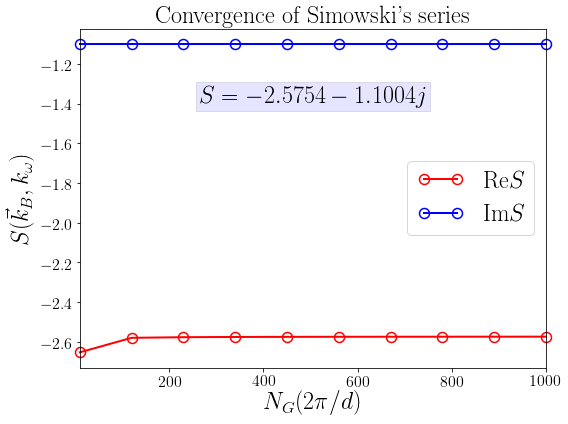

In [587]:
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)
f = plt.figure(figsize=(8,6))
ax = f.add_subplot(111)
plt.plot(gmax_list, np.real(simos), 'ro-', \
         label=r'$\mathrm{Re}S$', **marker_style)
plt.plot(gmax_list, np.imag(simos), 'bo-', \
         label=r'$\mathrm{Im}S$', **marker_style)
plt.xlim((gmax_list[0], gmax_list[-1]))
plt.xlabel(r'$N_G(2\pi/d)$')
plt.ylabel(r'$S({\vec{k}_B, k_{\omega}})$')
plt.title("Convergence of Simowski's series")
plt.legend(loc='best', numpoints=2, fontsize=24)
plt.text(0.5, 0.8, "$S={:.4f}$".format(simos[-1]),\
         horizontalalignment='center',\
         verticalalignment='center',\
         transform=ax.transAxes, \
         bbox=dict(facecolor='blue', alpha=0.1),\
         fontsize=24)
plt.tight_layout()
plt.savefig('simowski-series.pdf')
plt.show()

# Ewald's Method Test

## $G_1$ and $G_2$ Test

E=1.86574089569
[ 0.64085638  0.29883624  0.        ]
[0.48, -0.91, 0.0]
G_1 = 0.175+0.460j
G_2 = -0.154-0.011j


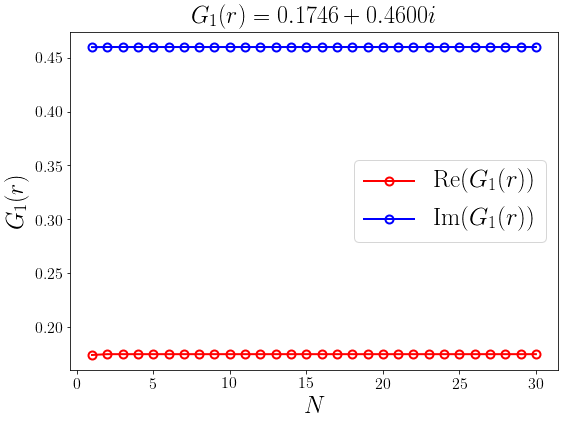

In [580]:
#######################################
#       g1_sum, g2_sum test
#######################################
square0=Lattice([0.95, 0, 0], \
                [0, 0.95, 0], \
                [0, 0, 1])
lat = square0
x, y, z = 0.48, -0.91, 0.0
# x, y, z = 0, 0, 0
k0 = (1.0+0.0j)*twopi
theta, phi = 45/180*np.pi, 25/180*np.pi
kx = np.real(k0)*np.sin(theta)*np.cos(phi)
ky = np.real(k0)*np.sin(theta)*np.sin(phi)
ax, ay = vec_norm(lat.a1), vec_norm(lat.a2)
epara = np.sqrt(np.pi/ax/ay)
print('E=%s'%epara)
kvec = [kx, ky, 0.0]
rvec = [x, y, z]
gvs = gmesh(2, 2, lat)
Rvs = rmesh(2, 2, lat)
print(np.array(kvec)/twopi)
print(rvec)

# G_1
gsum1 = g1_sum(2, 2, rvec, kvec, k0, epara, lat)/4.0/np.pi
print('G_1 = {:.3f}'.format(gsum1))

# G_2
gsum2 = g2_sum(2, 2, rvec, kvec, k0, epara, lat)/4.0/np.pi
print('G_2 = {:.3f}'.format(gsum2))

# G_1 vs N
N = 30
gsumlist = [ g1_sum(N1, N1, rvec, kvec, k0, epara, lat)/4.0/np.pi \
            for N1 in np.arange(1,N+1) ]

# Plot
plt.figure(figsize=(8,6))
plt.plot(range(1,N+1), np.real(gsumlist), 'ro-', \
         label='$\mathrm{Re}(G_1(r))$',
        markersize=8, markerfacecolor="None", markeredgewidth=2)
plt.plot(range(1,N+1), np.imag(gsumlist), 'bo-', \
         label='$\mathrm{Im}(G_1(r))$',
        markersize=8, markerfacecolor="None", markeredgewidth=2)
plt.legend(loc='best',fontsize=25)
plt.xlabel('$N$')
plt.ylabel('$G_1(r)$')
plt.title('$G_1(r)=%5.4f+%5.4fi$' % \
          (np.real(gsumlist[-1]), np.imag(gsumlist[-1])))
plt.tight_layout()
plt.savefig('g1-test.pdf')
plt.show()

## Evolution of $G_i(r)$ with Ewald parameter $E$

E=1.7725


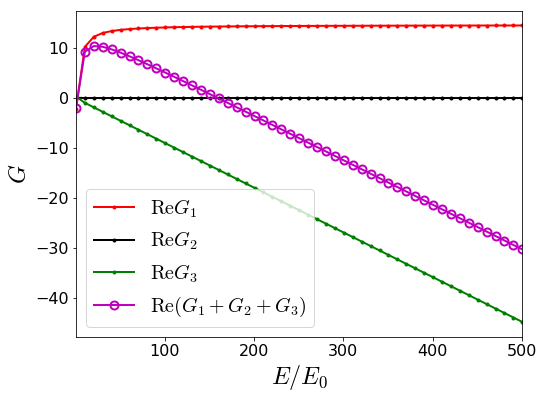

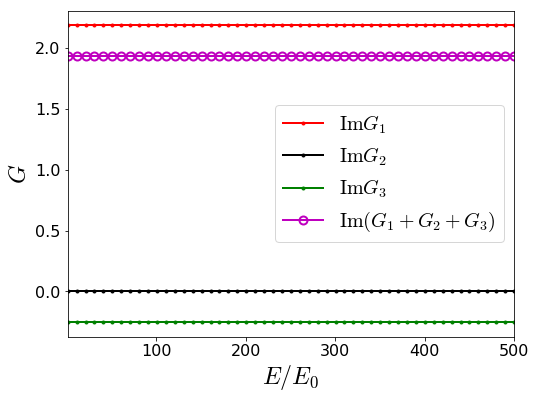

Convergenec of Re(g1s): 1.4004e-04


In [818]:
lat = square
rvec = [0.0, 0, 0]
kvec = [twopi*0.8, 0, 0]
kw = 0.5*twopi
d1 = vec_norm(lat.a1)
d2 = vec_norm(lat.a2)
E_opt = np.sqrt( np.pi * (1.0/d1**2 + 1.0/d2**2) / (d1**2 + d2**2) )
print("E={:.4f}".format(E))

nrx, nry = 2, 2
nkx, nky = 2, 2
rs = rmesh(nrx, nry, lat, rmin=0) #, rmax=100*vec_norm(lat.a1))
gs = gmesh(nkx, nky, lat) #, gmax=100*vec_norm(lat.b1))
# plot_grid(rs)
# plot_grid(gs)
# %time np.sum(g1term(rvec, kvec, kw, E, gs, lat))
# s1 = g1_sum(nx, ny, rvec, kvec, kw, E, lat)
# s2 = g1_sum(None, None, rvec, kvec, kw, E, lat, gs=gs)
# print(np.real((s2 - s1))/np.real(s1), np.imag((s2 - s1))/np.imag(s1))

es = np.linspace(1, 500, 51)
g1s = [ g1_sum(nkx, nky, rvec, kvec, kw, E*E_opt, lat, grid=gs) for E in es]
g2s = [ g2_sum(nrx, nry, rvec, kvec, kw, E*E_opt, lat, grid=rs) for E in es]
g3s = [ g3(kw, E) for E in es]

plt.figure(figsize=(8,6))
plt.plot(es, np.real(g1s), 'ro-', label='$\mathrm{Re}G_1$')
plt.plot(es, np.real(g2s), 'ko-', label='$\mathrm{Re}G_2$')
# plt.plot(es, np.real(g1s)+np.real(g2s), 'bo-', label='$\mathrm{Re}(G_1+G_2)$')
plt.plot(es, np.real(g3s)/4.0/np.pi, 'go-', label='$\mathrm{Re}G_3$')
plt.plot(es, np.real(g1s)+np.real(g2s)+np.real(g3s)/4.0/np.pi,
         'mo-', label='$\mathrm{Re}(G_1+G_2+G_3)$',
         markerfacecolor='None', markersize=8, markeredgewidth=2)
plt.xlabel('$E/E_0$')
plt.ylabel('$G$')
plt.xlim((es.min(), es.max()))
plt.legend(loc=0, fontsize=20)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(es, np.imag(g1s), 'ro-', label='$\mathrm{Im}G_1$')
plt.plot(es, np.imag(g2s), 'ko-', label='$\mathrm{Im}G_2$')
# plt.plot(es, np.imag(g1s)+np.imag(g2s), 'bo-', label='$\mathrm{Im}(G_1+G_2)$')
plt.plot(es, np.imag(g3s)/4.0/np.pi, 'go-', label='$\mathrm{Im}G_3$')
plt.plot(es, np.imag(g1s)+np.imag(g2s)+np.imag(g3s)/4.0/np.pi, \
         'mo-', label='$\mathrm{Im}(G_1+G_2+G_3)$', \
         markerfacecolor='None', markersize=8, markeredgewidth=2)
plt.xlabel('$E/E_0$')
plt.ylabel('$G$')
plt.xlim((es.min(), es.max()))
plt.legend(loc=0, fontsize=20)
plt.show()

deviation = np.abs ( np.real(g1s[-1]) - np.real(g1s[-2]) )/ np.real(g1s[-2])
print("Convergenec of Re(g1s): {:.4e}".format(deviation))

# Comparison of Direct Sum, Simowski-Zhen and Ewald

## Direct Sum Convergence Test

In [210]:
# Test parameters
lat = square
r0 = [0, 0, 0]
kw = twopi*0.5
k = [ twopi*0.8, 0, 0 ]

# Direct summation
# numR = 500
# %time grid = rmesh(numR, numR, lat, rmin=0)
# plot_grid(grid)
# %time Rsum_direct(fR1, numR, [0,0,0], k, kw, lat)

In [211]:
# Convergence of direct summation
Ns = np.arange(30, 3100, 300)
%time Rsums = [ Rsum_direct(fR1, numR, r0, k, kw, lat)\
               for numR in Ns ]

CPU times: user 38.3 s, sys: 27.4 s, total: 1min 5s
Wall time: 1min 8s


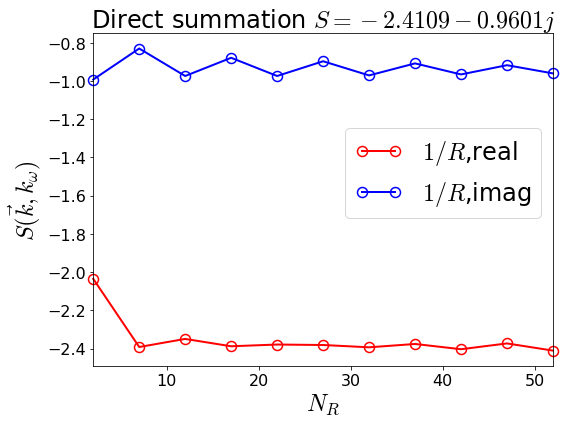

In [388]:
# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(Ns, np.real(Rsums), 'ro-', label=r'$1/R$,real', \
        **marker_style)
plt.plot(Ns, np.imag(Rsums), 'bo-', label=r'$1/R$,imag', \
        **marker_style)
plt.xlim((Ns[0], Ns[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$S(\vec{k}, k_{\omega})$')
plt.title("Direct summation $S={:.4f}$".format(Rsums[-1]))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-sum.pdf')
plt.show()

## Convergence of Ewald's Method

CPU times: user 61.7 ms, sys: 10.9 ms, total: 72.6 ms
Wall time: 47.5 ms


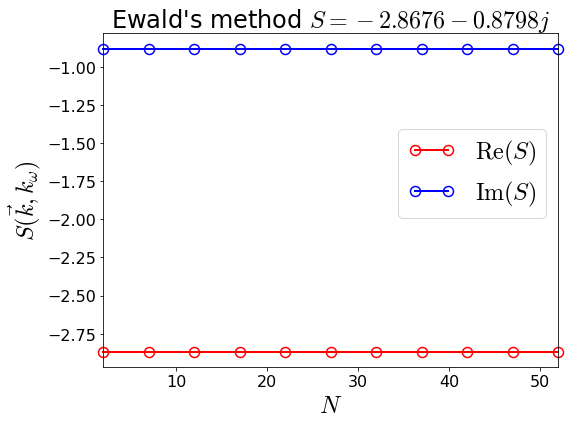

In [389]:
# Convergence test for Ewald's method vs 
ax, ay = vec_norm(lat.a1), vec_norm(lat.a2)
E0 = np.sqrt(np.pi/ax/ay)
E = 1.0
# number of terms
Ns = np.arange(2, 55, 5)
%time S_ewald_N = [ S_ewald(k, kw, n, n, E*E0, lat, 1, 1, 1)\
            for n in Ns]

marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(Ns, np.real(S_ewald_N), 'ro-', label='$\mathrm{Re}(S)$',\
        **marker_style)
plt.plot(Ns, np.imag(S_ewald_N), 'bo-', label='$\mathrm{Im}(S)$',\
        **marker_style)
plt.xlim((Ns[0], Ns[-1]))
plt.xlabel('$N$')
plt.ylabel(r'$S(\vec{k}, k_{\omega})$')
plt.title("Ewald's method $S={:.4f}$".\
          format(S_ewald_N[-1]))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('ewald-convergence.pdf')
plt.show()

## Comparison of Three methods

In [390]:
kw = twopi*0.5
k = [ twopi*0.8, 0, 0 ]

# Direct summation
numR = 1000
%time S_direct = Rsum_direct(fR1, numR, r0, k, kw, lat)
print("Direct summation S: {:.4f}".format(S_direct))

# Direct summation
# numR = 3000
# %time S_direct = Rsum_direct(fR1, numR, r0, k, kw, lat)
# print("Direct summation S: {:.4f}".format(S_direct))

# Ewald
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5
print('E={:.6f}'.format(E))
print('k={}, kw={:.4f}'.format(k, kw))
%time S_Ewald = S_ewald(k, kw, N_G, N_R, 1*E, lat, 1, 1, 1)
print("S(k, kw) using Ewald's method: {:.4f}".format(S_Ewald))

# Simowski
Gmax = 320*np.pi
%time S_simzhen = S_simowski(k, kw, Gmax, D, lat)
print("S(k, kw) using Simowski-Zhen method: {:.4f}"\
      .format(S_simzhen))
# print("S(k, kw) using Simowski-Zhen method: {:.4f}"\
#       .format(simos[-1]))

CPU times: user 999 ms, sys: 465 ms, total: 1.46 s
Wall time: 1.4 s
Direct summation S: -2.5056-0.5486j
E=1.865741
k=[5.026548245743669, 0, 0], kw=3.1416
CPU times: user 1.59 ms, sys: 893 µs, total: 2.49 ms
Wall time: 1.52 ms
S(k, kw) using Ewald's method: -2.5972-0.5736j
CPU times: user 58.4 ms, sys: 58 ms, total: 116 ms
Wall time: 126 ms
S(k, kw) using Simowski-Zhen method: -2.4020-0.5736j


In [391]:
ks = twopi * np.linspace(1e-6, 1.0, 1001)
%time s0 = [ S_ewald([k, 0, 0], kw, N_G, N_R, 1*E, lat, 1, 1, 1) for k in ks ]

CPU times: user 672 ms, sys: 6.76 ms, total: 678 ms
Wall time: 691 ms


### Evolution of $S(\vec{k}, k_{\omega})$ vs. $k$

In [392]:
kw = 0.1*twopi
nk = 501
ks = twopi * np.linspace(1e-6, 1.0, nk)
ks = twopi * np.linspace(1e-3, 1.8, nk)
s1k = [ S_ewald([k, 0, 0], kw, N_G, N_R, 1*E, lat, 1, 1, 1) for k in ks ]
Gmax = 320*np.pi
s2k = [ S_simowski([k, 0, 0], kw, Gmax, D, lat) for k in ks ]
# np.savetxt('s_ewald_k.txt', s1, fmt='%.4f')

In [393]:
# Save data
with open('s-k-compare.txt', 'w') as f:
    for k, s1, s2 in zip(ks/twopi, s1k, s2k):
        f.write("{:.6f}\t{:.6f}\t{:.6f} \n".format(k, s1, s2))

# Load and plot
# x, y1, y2 = np.loadtxt('data.txt', dtype=np.complex_).T
# plt.plot(x, np.real(y1), 'ro-')
# plt.plot(x, np.imag(y1), 'go-')
# plt.plot(x, np.real(y2), 'bo-')
# plt.plot(x, np.imag(y2), 'ko-')
# plt.show()

# # Save data using numpy.savetxt
# data = np.array([ks/twopi, s1k, s2k], dtype=object).T
# print(data[0])
# # np.savetxt('s-k-compare.txt', data, fmt='%.4f, %.4f+%.4fj, %.4f+%.4fj')
# # np.savetxt('s-k-compare.txt', data, fmt=['%.4f','%.4f+%.4fj','%.4f+%.4fj'])

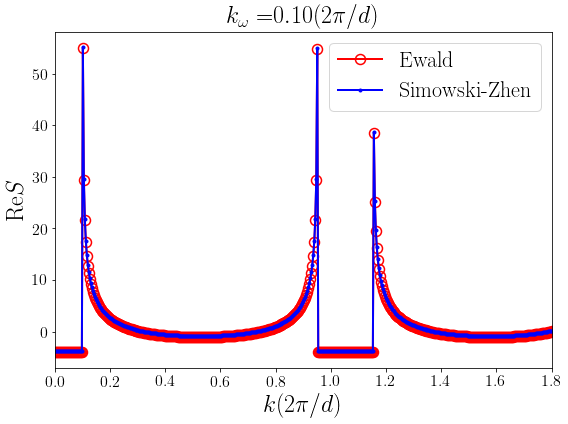

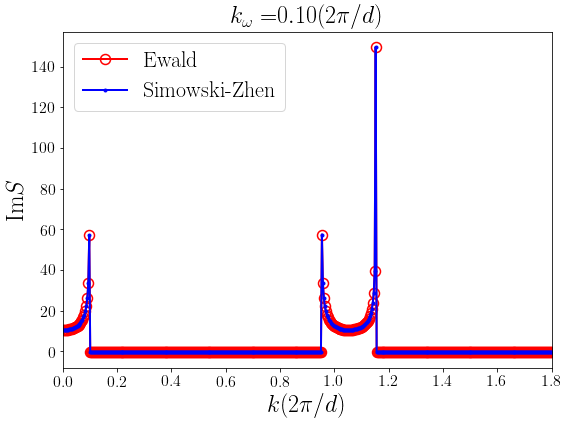

In [581]:
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(ks/twopi, np.real(s1k), 'ro-',\
         label='Ewald', **marker_style)
plt.plot(ks/twopi, np.real(s2k), 'bo-',\
        label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k(2\pi/d)$')
plt.ylabel('$\mathrm{Re}S$')
plt.title(r"$k_{\omega}=$"+"${:.2f}(2\pi/d)$".format(kw/twopi))
plt.xlim((ks[0]/twopi, ks[-1]/twopi))
# plt.ylim((-10,30))
plt.tight_layout()
plt.savefig('s-k-compare-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(ks/twopi, np.imag(s1k), 'ro-',\
         label='Ewald', **marker_style)
plt.plot(ks/twopi, np.imag(s2k), 'bo-',\
        label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k(2\pi/d)$')
plt.ylabel('$\mathrm{Im}S$')
plt.title(r"$k_{\omega}=$"+"${:.2f}(2\pi/d)$".format(kw/twopi))
plt.xlim((ks[0]/twopi, ks[-1]/twopi))
# plt.xlim((0.8, 1.0))
# plt.ylim((-100,100))
plt.tight_layout()
plt.savefig('s-k-compare-imag.pdf')
plt.show()

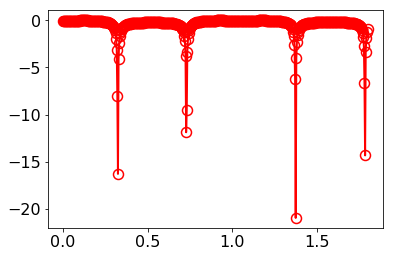

In [402]:
def rel_err(x, y):
    return (x - y)/np.fabs(y)

marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=True)
plt.plot(ks/twopi, rel_err(np.real(s1k), np.real(s2k)), 'ro-', **marker_style)
# plt.ylim((-1e-1,0))
plt.show()

### Evolution of $S(\vec{k}, k_{\omega})$ vs. $k_{\omega}$

In [403]:
k = [0.3*twopi, 0, 0]
nkw = 501
kws = twopi * np.linspace(1e-6, 1.5, nkw)
%time s1kw = [ S_ewald(k, kw, N_G, N_R, 1*E, lat, 1, 1, 1) for kw in kws ]
Gmax = 320*np.pi
%time s2kw = [ S_simowski(k, kw, Gmax, D, lat) for kw in kws ]

CPU times: user 338 ms, sys: 3.14 ms, total: 341 ms
Wall time: 343 ms
CPU times: user 22.3 s, sys: 7.04 s, total: 29.3 s
Wall time: 29.7 s


In [404]:
# Save data
with open('s-kw-compare.txt', 'w') as f:
    for kw, s1, s2 in zip(kws/twopi, s1kw, s2kw):
        f.write("{:.6f}\t{:.6f}\t{:.6f} \n".format(kw, s1, s2))

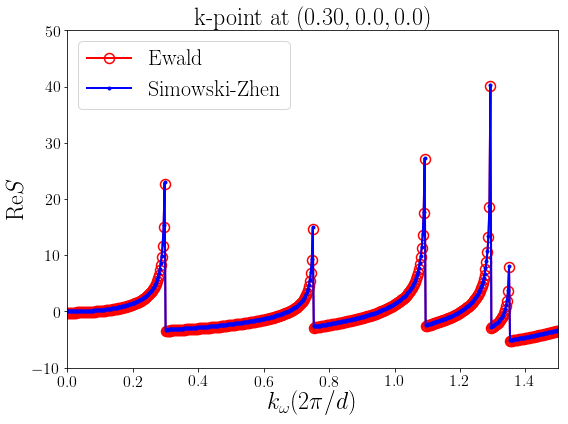

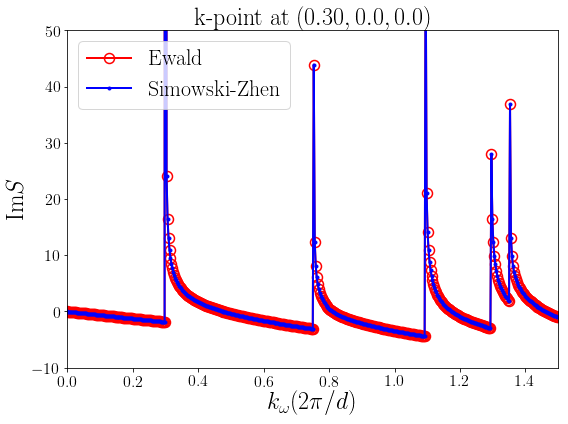

In [575]:
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(kws/twopi, np.real(s1kw), 'ro', \
         label='Ewald', **marker_style)
plt.plot(kws/twopi, np.real(s2kw), 'bo-', \
         label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k_{\omega}(2\pi/d)$')
plt.ylabel('$\mathrm{Re}S$')
plt.title('k-point at $({:.2f},{},{})$'.\
          format(k[0]/twopi, k[1]/twopi, k[2]/twopi))
plt.xlim((kws[0]/twopi, kws[-1]/twopi))
plt.ylim((-10,50))
plt.tight_layout()
plt.savefig('s-kw-compare-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(kws/twopi, np.imag(s1kw), 'ro', \
         label='Ewald', **marker_style)
plt.plot(kws/twopi, np.imag(s2kw), 'bo-', \
         label='Simowski-Zhen')
plt.legend(loc='best', fontsize=22)
plt.xlabel('$k_{\omega}(2\pi/d)$')
plt.ylabel('$\mathrm{Im}S$')
plt.title('k-point at $({:.2f},{},{})$'.\
          format(k[0]/twopi, k[1]/twopi, k[2]/twopi))
plt.xlim((kws[0]/twopi, kws[-1]/twopi))
plt.ylim((-10,50))
plt.tight_layout()
plt.savefig('s-kw-compare-imag.pdf')
plt.show()

$$
-ik_{\omega}\mathrm{erfc}(-\frac{ik_{\omega}}{2E})
=-ik_{\omega} - ik_{\omega}\mathrm{erf}(\frac{ik_{\omega}}{2E})
$$

In [414]:
def dterm(x):
    x = np.asarray(x)
    return erfc(np.sqrt(np.pi)*x)/x

In [424]:
ns = [1.0, np.sqrt(2.0), 2, np.sqrt(5)]
# print(ns)
print(dterm(ns))
D_ewald = (2*dterm(ns).sum() - 1.0 ) * 4.0
print(D_ewald)

[  1.21888822e-02   2.77716604e-04   2.67582331e-07   9.31391746e-09]
-3.90026499452


In [423]:
dterm(ns).sum()

0.012466875685343578

# Band Structure

## Quasi-static limit

In [504]:
fR3 = lambda Rvec: fRn(Rvec, 3)
kw = 0.1*twopi
kvec = [0.11*twopi, 0, 0]
r0 = [0, 0, 0]
nx, ny = 10, 10
lat = square
# grid = rmesh(nx, ny, lat)
# plot_grid(grid)
%time print(Rsum_direct(fR3, nx, r0, kvec, kw, lat))

(3.91482098958+3.68583479247j)
CPU times: user 898 µs, sys: 553 µs, total: 1.45 ms
Wall time: 933 µs


In [505]:
Ns = np.arange(30, 1000, 100)
%time Rsums = [ Rsum_direct(fR3, numR, r0, kvec, kw, lat)\
               for numR in Ns ]

CPU times: user 4.04 s, sys: 1.59 s, total: 5.63 s
Wall time: 5.36 s


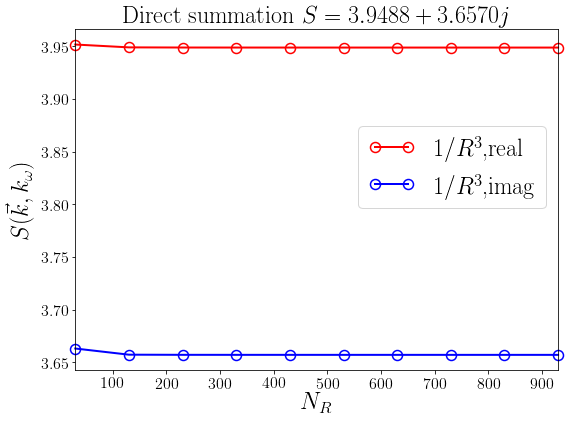

In [573]:
# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(Ns, np.real(Rsums), 'ro-', label=r'$1/R^3$,real', \
        **marker_style)
plt.plot(Ns, np.imag(Rsums), 'bo-', label=r'$1/R^3$,imag', \
        **marker_style)
plt.xlim((Ns[0], Ns[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$S(\vec{k}, k_{\omega})$')
plt.title("Direct summation $S={:.4f}$".format(Rsums[-1]))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-sum.pdf')
plt.show()

### Comparison of interaction of different range

CPU times: user 320 ms, sys: 99.9 ms, total: 420 ms
Wall time: 359 ms
CPU times: user 342 ms, sys: 112 ms, total: 454 ms
Wall time: 284 ms
CPU times: user 423 ms, sys: 127 ms, total: 550 ms
Wall time: 306 ms


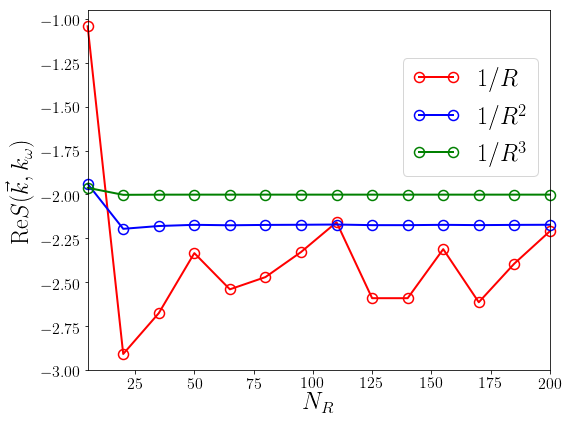

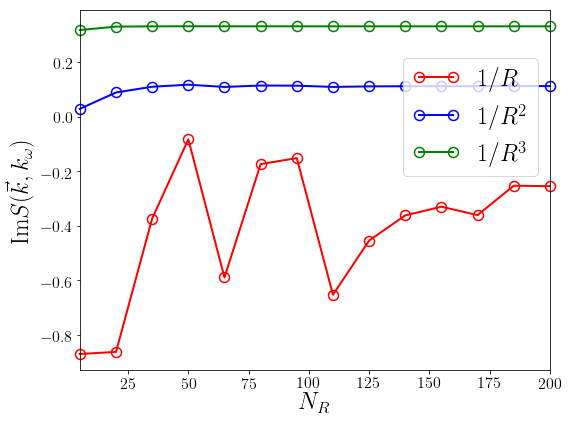

In [584]:
# Sample calculation for 1/R, 1/R^2 and 1/R^3 lattice sums
r0 = [0, 0, 0]
kvec = [0.3*twopi, 0, 0]
kw = 0.5*twopi
lat_test = square0
nums = np.arange(5, 205, 15)

fR1 = lambda Rvec: fRn(Rvec, 1)
fR2 = lambda Rvec: fRn(Rvec, 2)
fR3 = lambda Rvec: fRn(Rvec, 3)
%time f1 = [ Rsum_direct(fR1, numR, r0, kvec, kw, lat_test) \
      for numR in nums ]
%time f2 = [ Rsum_direct(fR2, numR, r0, kvec, kw, lat_test) \
      for numR in nums ]
%time f3 = [ Rsum_direct(fR3, numR, r0, kvec, kw, lat_test) \
      for numR in nums ]

marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                   clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(nums, np.real(f1), 'ro-', label=r'$1/R$', \
        **marker_style)
plt.plot(nums, np.real(f2), 'bo-', label=r'$1/R^2$', \
        **marker_style)
plt.plot(nums, np.real(f3), 'go-', label=r'$1/R^3$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Re}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-R-sum-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(nums, np.imag(f1), 'ro-', label=r'$1/R$', \
        **marker_style)
plt.plot(nums, np.imag(f2), 'bo-', label=r'$1/R^2$', \
        **marker_style)
plt.plot(nums, np.imag(f3), 'go-', label=r'$1/R^3$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Im}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
plt.tight_layout()
plt.savefig('direct-R-sum-imag.pdf')
plt.show()

### Error scaling of direct summation

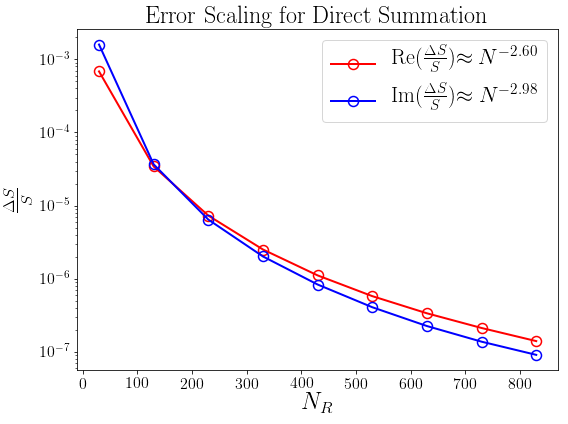

In [569]:
sums = np.array(Rsums)
err_re = rel_err( sums.real[1:], sums.real[:-1] )
err_im = rel_err( sums.imag[1:], sums.imag[:-1] )

power1, y1 = np.polyfit(np.log(Ns[:-1]), np.log(np.fabs(err_re)), 1)
# print(power1, y1)
power2, y2 = np.polyfit(np.log(Ns[:-1]), np.log(np.fabs(err_im)), 1)
# print(power2, y2)

label1 = r'$\mathrm{Re}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power1)
label2 = r'$\mathrm{Im}(\frac{\Delta S}{S})$' + \
r'$\approx N^{{ {:.2f} }}$'.format(power2)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.semilogy(Ns[:-1], np.fabs(err_re), 'ro-', 
             label=label1, **marker_style)
# plt.semilogy(Ns[:-1], np.power(Ns[:-1], power1)*np.exp(y1), 'ko-')
plt.semilogy(Ns[:-1], np.fabs(err_im), 'bo-',
             label=label2, **marker_style)
plt.xlabel(r'$N_R$')
plt.ylabel(r'$\frac{\Delta S}{S}$')
plt.title(r'Error Scaling for Direct Summation')
plt.legend(loc='best', fontsize=22)
# plt.text(0.7, 0.9, \
#          r'$\frac{{\Delta S}}{{S}}\approx N^{{ {:.2f} }}$'.format(power1),\
#          horizontalalignment='center',\
#          verticalalignment='center',\
#          transform=ax.transAxes, \
#          bbox=dict(facecolor='None', alpha=0.1),fontsize=24)
# plt.annotate(r'$\mathrm{Re}(\frac{\Delta S}{S})$'+
#              r'$\approx N^{{ {:.2f} }}$'.format(power1),
#              xy=(0.5, 0.85), xycoords='axes fraction', fontsize=24)
# plt.annotate(r'$\mathrm{Im}(\frac{\Delta S}{S})$'+
#              r'$\approx N^{{ {:.2f} }}$'.format(power2),
#              xy=(0.5, 0.65), xycoords='axes fraction', fontsize=24)
plt.tight_layout()
plt.savefig('direct-sum-error.pdf')
plt.show()

In [592]:
erfc(np.sqrt(np.pi)*np.sqrt(8))/np.sqrt(8)

4.747904071384287e-13

In [520]:
# Rsum_direct(fR3, numR, r0, kvec, kw, lat)
def diff_S_k(kvec, udk, dk, kw, lat, N_R, sum_func):
    kvec = np.array(kvec)
    udk = np.array(udk)
#     uk = kvec/vec_norm(kvec)
#     return udk
    k1, k2 = kvec - dk/2.0*udk, kvec + dk/2.0*udk
    s1 = Rsum_direct(sum_func, N_R, [0, 0, 0], k1, kw, lat)
    s2 = Rsum_direct(sum_func, N_R, [0, 0, 0], k2, kw, lat)
    return ( s2 - s1 ) / dk

In [535]:
dk = 1e-4
kvec = [0.11*twopi, 0, 0]
kvec = [0.11*twopi, 0.11*twopi, 0]
udk = [1, 0, 0]
kw = 0.1*twopi
N_R = 300
fR3 = lambda Rvec: fRn(Rvec, 3)

%time diff_S_k(kvec, udk, dk, kw, lat, N_R, fR3)

CPU times: user 316 ms, sys: 104 ms, total: 419 ms
Wall time: 262 ms


(-2.095040560790018-2.6441754773687265j)

In [538]:
dsdk1 = diff_S_k(kvec, udk, dk, kw, lat, 100, fR3)
dsdk2 = diff_S_k(kvec, udk, dk, kw, lat, 300, fR3)

In [539]:
rel_err(dsdk1.real, dsdk2.real), rel_err(dsdk1.imag, dsdk2.imag)

(-0.00014239951863576175, 0.00018867256520610441)

### Transverse Mode

In [ ]:
fR3 = lambda Rvec: fRn(Rvec, 3)
kw = 0.0*twopi
kvec = [0.11*twopi, 0, 0]
r0 = [0, 0, 0]
nx, ny = 10, 10
lat = square
# grid = rmesh(nx, ny, lat)
# plot_grid(grid)
%time print(Rsum_direct(fR3, nx, r0, kvec, kw, lat))